In [ ]:
mkdir /content/data

mkdir: cannot create directory ‘/content/data’: File exists


In [ ]:
cd /content/data

/content/data


dataフォルダに「auto_mgp.csv」をアップロード

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 回帰のためのモジュールをインポート
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeRegressor

# 前処理用のモジュールをインポート
from sklearn.covariance import MinCovDet  # 外れ値処理用
from sklearn.preprocessing import PolynomialFeatures  # 相互特徴量生成用


from sklearn.model_selection import train_test_split

%matplotlib inline

from sklearn.preprocessing import StandardScaler

import pickle

In [ ]:
# 学習評価用関数
def learn(x, t, model):
    x_train, x_val, y_train, y_val = train_test_split(x, t, test_size = 0.2, random_state = 0)
    # 学習
    model.fit(x_train, y_train)
    # 訓練データと検証データの正解率計算
    train_score = model.score(x_train, y_train)
    val_score = model.score(x_val, y_val)
    return train_score, val_score


# グラフ表示関数
def plot_progress(data, title):
  tmp = pd.DataFrame(data)
  tmp.plot.line(x=tmp.columns[0], style=['r.-', 'bo-'], title=title)


# 散布図表示関数
def plot_scatter(data, t_col):
  colname = data.columns
  for name in colname:
    data.plot(kind='scatter', x=name, y=t_col)


# 相関係数の一覧を出力する関数
def print_corrs(data, t_col):
  # 特徴量として選択する項目の相関係数に対する閾値
  threshold = {
    '非常に強い相関(0.9以上)':[1.0, 0.9],
    '強い相関(0.7以上)':[0.9, 0.7],
    '相関あり(0.5以上)':[0.7, 0.5],
    '弱い相関(0.3以上)':[0.5, 0.3],
    '相関なし(0.3未満)':[0.3, 0.0]
    }

  val_corr_abs = data.corr()[t_col].map(abs).sort_values(ascending=False)

  print(f'正解データ「{t_col}」に対する各特徴量の相関係数')

  for k in threshold:
    print('---', k, '---')
    for i in val_corr_abs[(threshold[k][0]>val_corr_abs) & (val_corr_abs>=threshold[k][1])].index:
      print(f'{i:8}\t{val_corr_abs[i]:.5f}')
    
    print()

In [ ]:
df0 = pd.read_csv('auto_mgp.csv')


In [ ]:
# 正解データの列名
t_col = 'MPG'

# 特徴量データの列名
x_col = df0.loc[:, 'Cylinders':'Origin'].columns
x_col

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'Origin'],
      dtype='object')

In [ ]:
df0.head()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,0,18.0,8,307.0,130.0,3504,12.0,70,1
1,1,15.0,8,350.0,165.0,3693,11.5,70,1
2,2,18.0,8,318.0,150.0,3436,11.0,70,1
3,3,16.0,8,304.0,150.0,3433,12.0,70,1
4,4,17.0,8,302.0,140.0,3449,10.5,70,1


In [ ]:
df0.tail()

,Unnamed: 0,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,393,27.0,4,140.0,86.0,2790,15.6,82,1
394,394,44.0,4,97.0,52.0,2130,24.6,82,2
395,395,32.0,4,135.0,84.0,2295,11.6,82,1
396,396,28.0,4,120.0,79.0,2625,18.6,82,1
397,397,31.0,4,119.0,82.0,2720,19.4,82,1


「Unnamed: 0」列は不要なインデックスなので、削除

In [ ]:
df0 = df0.drop(['Unnamed: 0'], axis=1)
df0.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504,12.0,70,1
1,15.0,8,350.0,165.0,3693,11.5,70,1
2,18.0,8,318.0,150.0,3436,11.0,70,1
3,16.0,8,304.0,150.0,3433,12.0,70,1
4,17.0,8,302.0,140.0,3449,10.5,70,1


Originは一見数値データだが、(origin == 1)はアメ車、(origin == 2)は欧州車、(origin == 3)は日本車​を表すことから、カテゴリーデータとみなされる

In [ ]:
# ダミー変数化
df_dummy = df0.replace({'Origin': {1:'America', 2:'Europe', 3:'Japan'}})

df_dummy = pd.concat([df_dummy, pd.get_dummies(df_dummy['Origin'], drop_first=False)], axis=1)
df_dummy = df_dummy.drop(['Origin'], axis=1)

df_dummy.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
0,18.0,8,307.0,130.0,3504,12.0,70,1,0,0
1,15.0,8,350.0,165.0,3693,11.5,70,1,0,0
2,18.0,8,318.0,150.0,3436,11.0,70,1,0,0
3,16.0,8,304.0,150.0,3433,12.0,70,1,0,0
4,17.0,8,302.0,140.0,3449,10.5,70,1,0,0


In [ ]:
# 特徴量データの列名
x_col = df_dummy.loc[:, 'Cylinders':'Japan'].columns
x_col

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'America', 'Europe', 'Japan'],
      dtype='object')

訓練データ・検証データ、テストデータに分割

In [ ]:
# 訓練データ・検証データ、テストデータに分割
train_val, test = train_test_split(df_dummy, test_size = 0.2, random_state = 0)

train_val.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
64,15.0,8,318.0,150.0,4135,13.5,72,1,0,0
55,27.0,4,97.0,60.0,1834,19.0,71,0,1,0
317,34.3,4,97.0,78.0,2188,15.8,80,0,1,0
102,26.0,4,97.0,46.0,1950,21.0,73,0,1,0
358,31.6,4,120.0,74.0,2635,18.3,81,0,0,1


欠損値処理

In [ ]:
# 欠損値の確認
print(train_val.isnull().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      5
Weight          0
Acceleration    0
Model Year      0
America         0
Europe          0
Japan           0
dtype: int64


Horsepowerに5件の欠損値があるため、欠損値処理を機械学習を用いて行う<br>
なお、時系列データではない為、線形補完は行えないため、重線形回帰を用いて補完する

In [ ]:
# 欠損値を含まない行で学習
non_df = train_val.dropna()
x = non_df.drop(['Horsepower'], axis=1)
t = non_df['Horsepower']
hp_regret_model = LinearRegression()
hp_regret_model.fit(x, t)

# 欠損値を含む行を抽出
condition = train_val['Horsepower'].isnull()
non_data = train_val.loc[condition]

non_data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
126,21.0,6,200.0,NaN,2875,17.0,74,1,0,0
374,23.0,4,151.0,NaN,3035,20.5,82,1,0,0
336,23.6,4,140.0,NaN,2905,14.3,80,1,0,0
354,34.5,4,100.0,NaN,2320,15.8,81,0,1,0
32,25.0,4,98.0,NaN,2046,19.0,71,1,0,0


In [ ]:
# 欠損値を除いたデータで値を予測
x = non_data.drop(['Horsepower'], axis=1)
pred = hp_regret_model.predict(x)

# 予測した値をセット
train_val2 = train_val.copy()
train_val2.loc[condition, 'Horsepower'] = pred

train_val2.loc[condition]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
126,21.0,6,200.0,94.375298,2875,17.0,74,1,0,0
374,23.0,4,151.0,74.939384,3035,20.5,82,1,0,0
336,23.6,4,140.0,98.240267,2905,14.3,80,1,0,0
354,34.5,4,100.0,76.507448,2320,15.8,81,0,1,0
32,25.0,4,98.0,59.461251,2046,19.0,71,1,0,0


外れ値処理

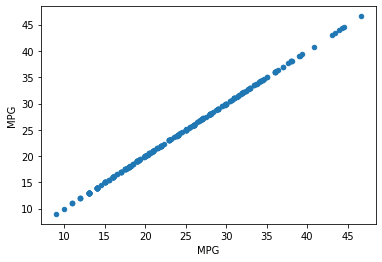

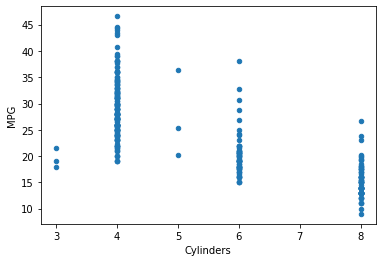

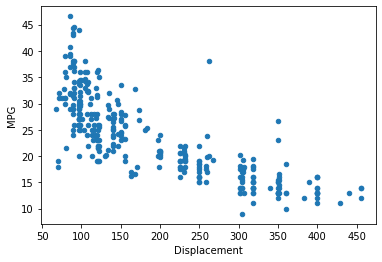

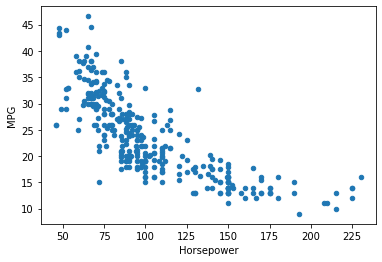

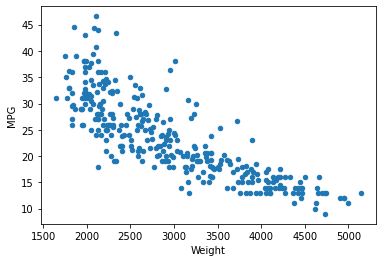

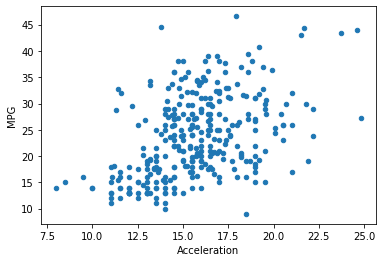

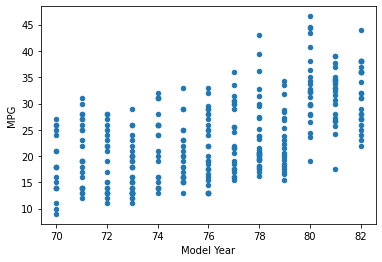

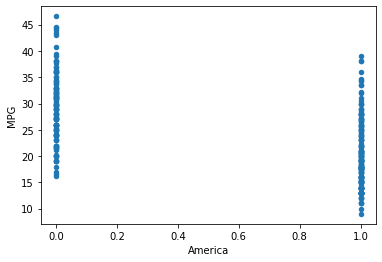

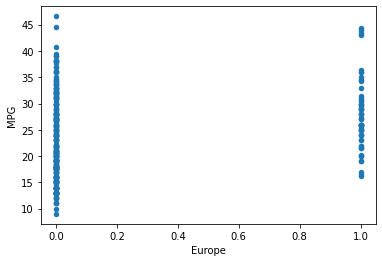

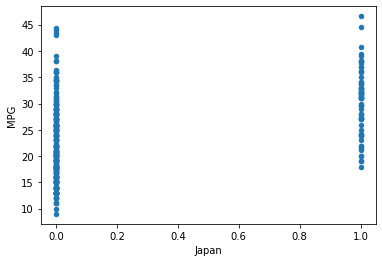

In [ ]:
plot_scatter(train_val2, t_col=t_col)

大きな外れ値はないので、Displacementに絞ってマハラノビス距離による処理を行う

In [ ]:
# マハラノビス距離を計算
mcd = MinCovDet(random_state=0, support_fraction=0.7)
train_val2_tmp = train_val2[['MPG', 'Displacement']]
mcd.fit(train_val2_tmp)

distance = pd.Series(mcd.mahalanobis(train_val2_tmp))
distance

0      1.455228
1      1.071633
2      4.943225
3      1.326861
4      2.993683
         ...   
313    1.224605
314    0.940060
315    1.684056
316    0.279626
317    2.139888
Length: 318, dtype: float64

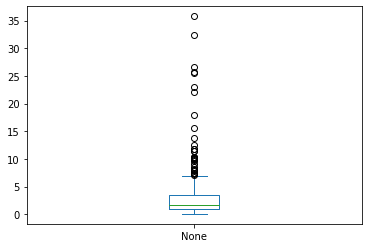

In [ ]:
# マハラノビス距離の分布を確認
distance.plot(kind='box')

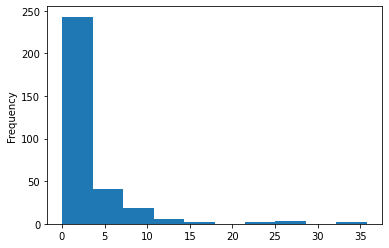

In [ ]:
distance.plot(kind='hist')

In [ ]:
# 四分位範囲を用いて外れ値のindexを確認
tmp = distance.describe()

iqr = tmp['75%'] - tmp['25%']
jougen = 1.5 * iqr + tmp['75%']
kagen = tmp['25%'] -1.5 * iqr
outliner = distance[(distance < kagen) | (jougen < distance)]
outliner

9      11.478747
11     10.014477
14      9.834394
24      8.069530
39     32.378733
54     10.271539
55     25.695207
56     15.539153
64      9.544133
76      7.307540
77     10.342869
81      8.486013
101     7.359276
109    22.906983
122    35.773921
130     7.991443
135    13.806470
144    12.469167
146    11.752546
147    10.014477
150    10.249870
172    25.566809
179     7.060391
191    11.748692
201     9.016581
209    26.638895
220     7.845478
222    10.249870
225     7.486647
227     8.096169
246    11.338615
247    17.856660
271    22.054448
286     7.474337
292     7.419643
dtype: float64

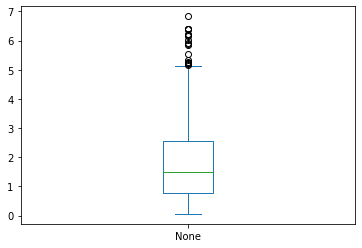

In [ ]:
# 削除後のマハラノビス距離の分布を確認
distance2 = distance.drop(outliner.index)
distance2.plot(kind='box')

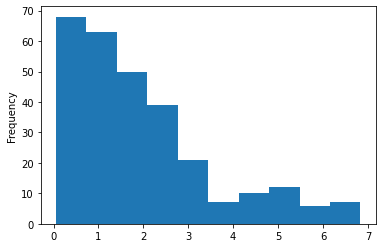

In [ ]:
distance2.plot(kind='hist')

In [ ]:
# 外れ値を除去
# outlinerはdistanceのインデックス番号の為、train_val2のインデックスラベルに置き換えて処理を行う
train_val3 = train_val2.drop(index=train_val2.index[outliner.index], axis=0)

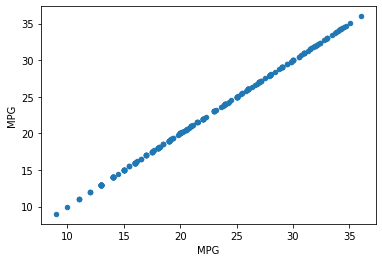

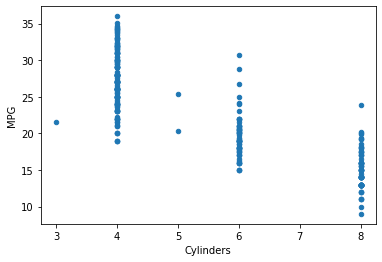

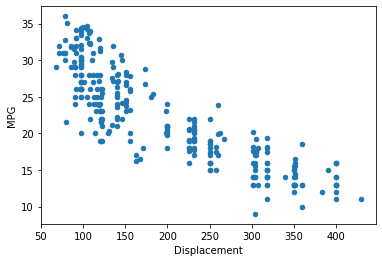

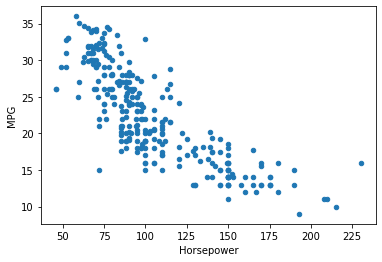

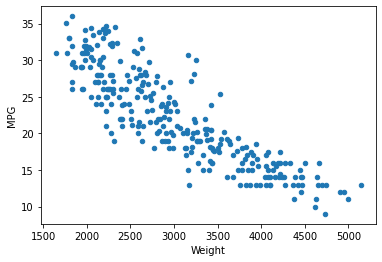

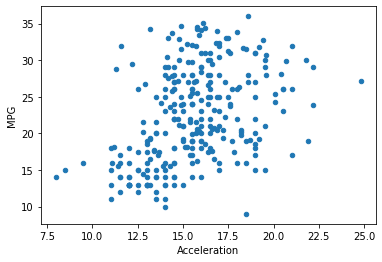

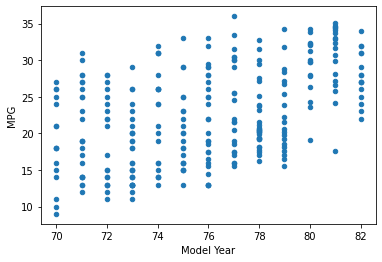

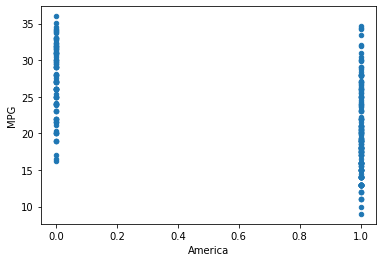

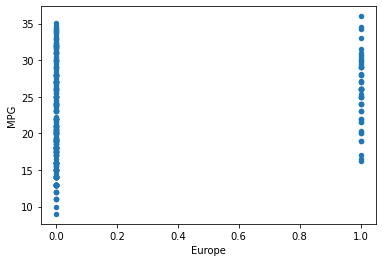

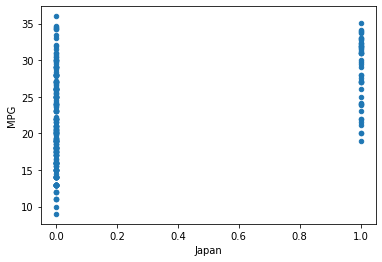

In [ ]:
# 削除後の散布図を確認
plot_scatter(train_val3, t_col=t_col)

学習開始

In [ ]:
# 正解データの抽出、標準化
y_train = train_val3.loc[:, [t_col]]
sc_y = StandardScaler()
sc_y_train = sc_y.fit_transform(y_train)

In [ ]:
# 相関係数を確認
print_corrs(train_val3, t_col=t_col)

正解データ「MPG」に対する各特徴量の相関係数
--- 非常に強い相関(0.9以上) ---

--- 強い相関(0.7以上) ---
Weight  	0.87119
Displacement	0.86421
Cylinders	0.83398
Horsepower	0.81900

--- 相関あり(0.5以上) ---
America 	0.55801

--- 弱い相関(0.3以上) ---
Model Year	0.46965
Japan   	0.43903
Acceleration	0.41440

--- 相関なし(0.3未満) ---
Europe  	0.26371



強い相関のあるWeight, Displacement, Horspower, Cylindersについて重回帰分析を行う

In [ ]:
x_col_LR = ['Weight', 'Displacement', 'Horsepower', 'Cylinders']
x_train_LR = train_val3.loc[:, x_col_LR]
x_train_LR.head()

,Weight,Displacement,Horsepower,Cylinders
64,4135,318.0,150.0,8
55,1834,97.0,60.0,4
317,2188,97.0,78.0,4
102,1950,97.0,46.0,4
358,2635,120.0,74.0,4


In [ ]:
# 特徴量データの標準化し、学習
sc_x_LR0 = StandardScaler()
sc_x_train_LR0 = sc_x_LR0.fit_transform(x_train_LR)
model_LR0 = LinearRegression()
x_score, t_score = learn(sc_x_train_LR0, sc_y_train, model_LR0)
print(f"x_score: {x_score:.3f}, t_score: {t_score:.3f}")


x_score: 0.779, t_score: 0.800


In [ ]:
# 累乗列と交互作用特徴量を一括追加
pf_LR = PolynomialFeatures(degree=2, include_bias=False)
pf_x_train_LR = pf_LR.fit_transform(x_train_LR)

# ..._out()を使うと元の列名を使ってくれるようです
pf_LR.get_feature_names_out()

array(['Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2',
       'Weight Displacement', 'Weight Horsepower', 'Weight Cylinders',
       'Displacement^2', 'Displacement Horsepower',
       'Displacement Cylinders', 'Horsepower^2', 'Horsepower Cylinders',
       'Cylinders^2'], dtype=object)

In [ ]:
# 特徴量を追加したデータをDataFrameに変換し、列名をつけなおす
x_train_LR2 = pd.DataFrame(pf_x_train_LR)

# LR_columns = ['Weight', 'Displacement', 'Horsepower', 'Cylinders', 'W2', 'WxD', 'WxH', 'WxC', 'D2', 'DxH', 'DxC', 'H2', 'HxC', 'C2']
LR_columns = pf_LR.get_feature_names_out()

x_train_LR2.columns = LR_columns
x_train_LR2.head()

,Weight,Displacement,Horsepower,Cylinders,Weight^2,Weight Displacement,Weight Horsepower,Weight Cylinders,Displacement^2,Displacement Horsepower,Displacement Cylinders,Horsepower^2,Horsepower Cylinders,Cylinders^2
0,4135.0,318.0,150.0,8.0,17098225.0,1314930.0,620250.0,33080.0,101124.0,47700.0,2544.0,22500.0,1200.0,64.0
1,1834.0,97.0,60.0,4.0,3363556.0,177898.0,110040.0,7336.0,9409.0,5820.0,388.0,3600.0,240.0,16.0
2,2188.0,97.0,78.0,4.0,4787344.0,212236.0,170664.0,8752.0,9409.0,7566.0,388.0,6084.0,312.0,16.0
3,1950.0,97.0,46.0,4.0,3802500.0,189150.0,89700.0,7800.0,9409.0,4462.0,388.0,2116.0,184.0,16.0
4,2635.0,120.0,74.0,4.0,6943225.0,316200.0,194990.0,10540.0,14400.0,8880.0,480.0,5476.0,296.0,16.0


In [ ]:
# 特徴量として最適な組み合わせを探索
# 処理時間の都合で、もともとあった特徴量はそのまま利用し、累乗列と交互作用特徴量のみで組み合わせる
import itertools, copy

max_score = 0
LR_pattern = []
LR_model = None
sc_x_LR = None

# 累乗、交互作用特徴量の列名を取り出す
tmp = LR_columns[:]

# 時短のため9以上の組み合わせから全パターンを試行
for i in range(8, len(tmp)):
  for pattern in itertools.combinations(tmp, i+1):
    # print(pattern)
    # x_tmp_col = copy.copy(x_col_LR)
    # x_tmp_col += pattern
    # x_tmp = x_train_LR2.loc[:, x_tmp_col]
    x_tmp = x_train_LR2.loc[:, pattern]

    model = LinearRegression()

    # 標準化
    sc_tmp = StandardScaler()
    sc_x_tmp = sc_tmp.fit_transform(x_tmp)

    x_score, t_score = learn(sc_x_tmp, sc_y_train, model)

    if t_score > max_score:
      # print(x_tmp_col)
      print(pattern)
      print(f"... x_score: {x_score:.4f}, t_score: {t_score:.4f}")
      print()
      max_score = t_score
      # LR_pattern = x_tmp_col
      LR_pattern = pattern
      LR_model = model
      sc_x_LR = sc_tmp

print()
print(f'特徴量として{LR_pattern}を選択したとき')
print(f'決定係数が最大値 {max_score:.4f}となる')

('Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2', 'Weight Displacement', 'Weight Horsepower', 'Weight Cylinders', 'Displacement^2')
... x_score: 0.8153, t_score: 0.8029

('Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2', 'Weight Displacement', 'Weight Horsepower', 'Weight Cylinders', 'Displacement Horsepower')
... x_score: 0.8233, t_score: 0.8277

('Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2', 'Weight Displacement', 'Weight Horsepower', 'Displacement^2', 'Displacement Horsepower')
... x_score: 0.8295, t_score: 0.8292

('Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2', 'Weight Horsepower', 'Weight Cylinders', 'Displacement^2', 'Displacement Horsepower')
... x_score: 0.8258, t_score: 0.8333

('Weight', 'Displacement', 'Horsepower', 'Cylinders', 'Weight^2', 'Weight Horsepower', 'Displacement^2', 'Displacement Horsepower', 'Displacement Cylinders')
... x_score: 0.8239, t_score: 0.8337

('Weight', 'Displacement', 'Horsepower',

In [ ]:
LR_model.coef_

array([[ 0.13118341, -2.75081288,  2.36221684, -2.5404938 ,  0.29583868,
         4.33254408, -7.50889041, -0.78665681,  5.60762318]])

リッジ回帰を行う

In [ ]:
# 特徴量データの抽出、累乗列と交互作用特徴量を一括追加
x_train = train_val3.loc[:, x_col]

# 定数項を入れることでy切片を調整する
pf = PolynomialFeatures(degree=2, include_bias=True)
pf_x = pf.fit_transform(x_train)
pf.get_feature_names_out()

array(['1', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
       'Acceleration', 'Model Year', 'America', 'Europe', 'Japan',
       'Cylinders^2', 'Cylinders Displacement', 'Cylinders Horsepower',
       'Cylinders Weight', 'Cylinders Acceleration',
       'Cylinders Model Year', 'Cylinders America', 'Cylinders Europe',
       'Cylinders Japan', 'Displacement^2', 'Displacement Horsepower',
       'Displacement Weight', 'Displacement Acceleration',
       'Displacement Model Year', 'Displacement America',
       'Displacement Europe', 'Displacement Japan', 'Horsepower^2',
       'Horsepower Weight', 'Horsepower Acceleration',
       'Horsepower Model Year', 'Horsepower America', 'Horsepower Europe',
       'Horsepower Japan', 'Weight^2', 'Weight Acceleration',
       'Weight Model Year', 'Weight America', 'Weight Europe',
       'Weight Japan', 'Acceleration^2', 'Acceleration Model Year',
       'Acceleration America', 'Acceleration Europe',
       'Acceleration Japan', 'Model Ye

In [ ]:
# 特徴量データの標準化
sc_x = StandardScaler()
sc_x_train = sc_x.fit_transform(pf_x)

まずは重回帰分析での決定係数を確認

In [ ]:
model_LR_tmp = LinearRegression()
x_score, t_score = learn(sc_x_train, sc_y_train, model_LR_tmp)
print(f"x_score: {x_score:.3f}, t_score: {t_score:.3f}")


x_score: 0.895, t_score: 0.854


特徴量を選択した時よりも結果が良くなってしまったが気にしない

In [ ]:
# 重回帰の係数を確認
# 絶対値で降順に表示する
pd.Series(model_LR_tmp.coef_[0], index=pf.get_feature_names_out()).map(abs).sort_values(ascending=False)

1                            4.394546e+12
Displacement Weight          1.005178e+01
Displacement Model Year      6.573380e+00
Horsepower Weight            6.269670e+00
Model Year                   5.277179e+00
Horsepower                   4.972849e+00
Model Year^2                 4.913419e+00
Displacement                 4.787963e+00
Cylinders Horsepower         4.672340e+00
Horsepower Model Year        4.122345e+00
Displacement^2               3.672683e+00
Displacement America         3.185366e+00
Acceleration                 2.693631e+00
Cylinders Displacement       2.330334e+00
Cylinders                    2.184872e+00
Horsepower Japan             2.085079e+00
Weight Japan                 1.611675e+00
Weight America               1.417489e+00
Acceleration Model Year      1.394818e+00
Horsepower Europe            1.368937e+00
Cylinders Model Year         1.366172e+00
Displacement Acceleration    1.362552e+00
Weight Europe                1.327538e+00
Model Year Japan             1.306

alpha: 0.01 ... x_score: 0.92733, t_score: 0.9157780
alpha: 0.02 ... x_score: 0.92560, t_score: 0.9191952
alpha: 0.03 ... x_score: 0.92427, t_score: 0.9208533
alpha: 0.04 ... x_score: 0.92320, t_score: 0.9218073
alpha: 0.05 ... x_score: 0.92231, t_score: 0.9224010
alpha: 0.06 ... x_score: 0.92156, t_score: 0.9227865
alpha: 0.07 ... x_score: 0.92091, t_score: 0.9230422
alpha: 0.08 ... x_score: 0.92033, t_score: 0.9232127
alpha: 0.09 ... x_score: 0.91982, t_score: 0.9233251
alpha: 0.1 ... x_score: 0.91937, t_score: 0.9233965
alpha: 0.11 ... x_score: 0.91896, t_score: 0.9234384
alpha: 0.12 ... x_score: 0.91859, t_score: 0.9234585
alpha: 0.13 ... x_score: 0.91824, t_score: 0.9234624

alpha = 0.13で、正解率が0.9234624となる


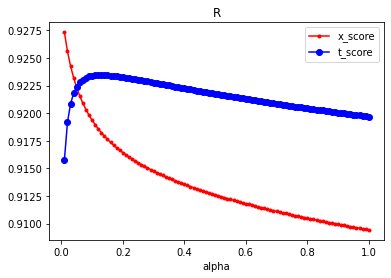

In [ ]:
# Ridgeで回帰分析

max_score = 0
R_model = None
max_alpha = 0
R_scores = []

num = 100
for i in range(num):
  a_val = (i+1)/100
  model = Ridge(random_state=0, alpha = a_val)
  x_score, t_score = learn(sc_x_train, sc_y_train, model)
  R_scores.append( {'alpha': a_val, 'x_score': x_score, 't_score': t_score} )
  if t_score > max_score:
    max_score = t_score
    R_model = model
    max_alpha = a_val
    print(f"alpha: {a_val} ... x_score: {x_score:.5f}, t_score: {t_score:.7f}")

print()
print(f"alpha = {max_alpha}で、正解率が{max_score:.7f}となる")

# 学習の度合いをグラフで表示
plot_progress(R_scores, title='R')


In [ ]:
# リッジ回帰の係数
pd.Series(R_model.coef_[0], index=pf.get_feature_names_out()).map(abs).sort_values(ascending=False)

Model Year^2                 1.183079
Displacement Weight          0.964016
Model Year                   0.836296
Cylinders Acceleration       0.795489
Acceleration                 0.773563
Displacement Horsepower      0.678421
Horsepower Weight            0.638382
Weight                       0.618271
Displacement Model Year      0.520131
Displacement                 0.430536
Horsepower Japan             0.408222
Cylinders                    0.389918
Displacement America         0.374809
Cylinders Weight             0.358601
Acceleration America         0.355671
Cylinders Model Year         0.355204
Horsepower America           0.343477
Weight America               0.334757
Cylinders^2                  0.313656
Cylinders Horsepower         0.307788
Cylinders Europe             0.299215
Displacement Acceleration    0.275074
Cylinders Displacement       0.247659
Horsepower^2                 0.243976
Acceleration^2               0.225944
Displacement^2               0.201650
Model Year J

In [ ]:
# 重回帰とリッジ回帰の係数の大きさを比較
print('重回帰:', sum(abs(model_LR_tmp.coef_)[0]))
print('リッジ:', sum(abs(R_model.coef_)[0]))

重回帰: 4394545879809.1714
リッジ: 14.742593670304293


リッジ回帰の方が回帰式の係数が小さくなった

alpha: 0.0005 ... x_score: 0.91739, t_score: 0.9186956


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_coordinate_descent.py:648: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.819e-02, tolerance: 2.275e-02
  coef_, l1_reg, l2_reg, X, y, max_iter, tol, rng, random, positive


alpha: 0.001 ... x_score: 0.90936, t_score: 0.9188630
alpha: 0.0025 ... x_score: 0.90362, t_score: 0.9195395

alpha = 0.0025で、正解率が0.9195395となる


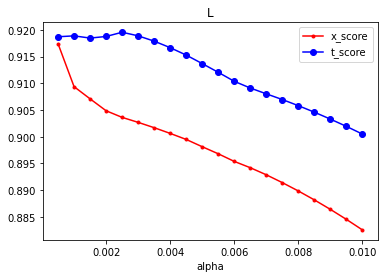

In [ ]:
# Lassoで回帰分析

max_score = 0
L_model = None
max_alpha = 0
L_scores = []

num = 20
for i in range(num):
  a_val = (i+1)/2000
  model = Lasso(random_state=0, alpha = a_val, max_iter=10000)
  x_score, t_score = learn(sc_x_train, sc_y_train, model)
  L_scores.append( {'alpha': a_val, 'x_score': x_score, 't_score': t_score} )
  if t_score > max_score:
    max_score = t_score
    L_model = model
    max_alpha = a_val
    print(f"alpha: {a_val} ... x_score: {x_score:.5f}, t_score: {t_score:.7f}")

print()
print(f"alpha = {max_alpha}で、正解率が{max_score:.7f}となる")

# 学習の度合いをグラフで表示
plot_progress(L_scores, title='L')

In [ ]:
# ラッソ回帰の回帰式の係数を確認
pd.Series(L_model.coef_, index=pf.get_feature_names_out()).map(abs).sort_values(ascending=False)

Displacement Model Year      0.856702
Displacement Weight          0.491698
Weight                       0.434251
Model Year^2                 0.379705
Displacement Horsepower      0.328709
Acceleration America         0.227361
Horsepower Model Year        0.196012
Horsepower Europe            0.191759
Horsepower Japan             0.170631
Horsepower Acceleration      0.129050
Weight Model Year            0.037721
Acceleration Japan           0.029867
Cylinders Acceleration       0.022568
Displacement Japan           0.009396
America^2                    0.000000
Europe^2                     0.000000
Weight^2                     0.000000
Weight Acceleration          0.000000
Europe Japan                 0.000000
Weight America               0.000000
Weight Europe                0.000000
America Japan                0.000000
Model Year Japan             0.000000
Weight Japan                 0.000000
Acceleration^2               0.000000
Acceleration Model Year      0.000000
Acceleration

In [ ]:
# 重回帰とラッソ回帰の係数の大きさを比較
print('重回帰:', sum(abs(model_LR_tmp.coef_)[0]))
print('ラッソ:', sum(abs(L_model.coef_)))

重回帰: 4394545879809.1714
ラッソ: 3.505428654963801


不要な特徴量が削除されていることが分かる

試しにラッソ回帰の結果をもとに重回帰分析を行ってみる

In [ ]:
# ラッソ回帰による特徴量の列名
tmp = pd.Series(L_model.coef_, index=pf.get_feature_names_out()).map(abs).sort_values(ascending=False)
L_columns = tmp[tmp>0].index
L_columns

Index(['Displacement Model Year', 'Displacement Weight', 'Weight',
       'Model Year^2', 'Displacement Horsepower', 'Acceleration America',
       'Horsepower Model Year', 'Horsepower Europe', 'Horsepower Japan',
       'Horsepower Acceleration', 'Weight Model Year', 'Acceleration Japan',
       'Cylinders Acceleration', 'Displacement Japan'],
      dtype='object')

In [ ]:
# ラッソ回帰による特徴量を抽出
tmp = pd.DataFrame(pf_x)
tmp.columns = pf.get_feature_names_out()
x_train_L = tmp.loc[:, L_columns]
x_train_L.head()

,Displacement Model Year,Displacement Weight,Weight,Model Year^2,Displacement Horsepower,Acceleration America,Horsepower Model Year,Horsepower Europe,Horsepower Japan,Horsepower Acceleration,Weight Model Year,Acceleration Japan,Cylinders Acceleration,Displacement Japan
0,22896.0,1314930.0,4135.0,5184.0,47700.0,13.5,10800.0,0.0,0.0,2025.0,297720.0,0.0,108.0,0.0
1,6887.0,177898.0,1834.0,5041.0,5820.0,0.0,4260.0,60.0,0.0,1140.0,130214.0,0.0,76.0,0.0
2,7760.0,212236.0,2188.0,6400.0,7566.0,0.0,6240.0,78.0,0.0,1232.4,175040.0,0.0,63.2,0.0
3,7081.0,189150.0,1950.0,5329.0,4462.0,0.0,3358.0,46.0,0.0,966.0,142350.0,0.0,84.0,0.0
4,9720.0,316200.0,2635.0,6561.0,8880.0,0.0,5994.0,0.0,74.0,1354.2,213435.0,18.3,73.2,120.0


In [ ]:
# 特徴量データの標準化
sc_x_L = StandardScaler()
sc_x_train_L = sc_x.fit_transform(x_train_L)

In [ ]:
# 重回帰分析で学習
model_LR2 = LinearRegression()
x_score, t_score = learn(sc_x_train_L, sc_y_train, model_LR2)
print(f"x_score: {x_score:.3f}, t_score: {t_score:.3f}")

x_score: 0.907, t_score: 0.915


In [ ]:
# ラッソ回帰によるの重回帰分析の回帰式の係数を確認
pd.Series(model_LR2.coef_[0], index=L_columns).map(abs).sort_values(ascending=False)

Displacement Model Year    1.189765
Weight                     1.083006
Displacement Weight        0.969521
Weight Model Year          0.433462
Horsepower Japan           0.410410
Model Year^2               0.322347
Displacement Japan         0.259955
Acceleration America       0.259743
Horsepower Europe          0.237825
Displacement Horsepower    0.207181
Horsepower Acceleration    0.148710
Horsepower Model Year      0.087881
Cylinders Acceleration     0.071230
Acceleration Japan         0.031905
dtype: float64

単純にラッソ回帰を行った場合と同程度の精度が出るようだ

回帰木を用いて分析する<br>
なお、決定木なので標準化は行わない

In [ ]:
x_train.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
64,8,318.0,150.0,4135,13.5,72,1,0,0
55,4,97.0,60.0,1834,19.0,71,0,1,0
317,4,97.0,78.0,2188,15.8,80,0,1,0
102,4,97.0,46.0,1950,21.0,73,0,1,0
358,4,120.0,74.0,2635,18.3,81,0,0,1


In [ ]:
y_train.head()

,MPG
64,15.0
55,27.0
317,34.3
102,26.0
358,31.6


max_depth:  1 ... x_score: 0.646, t_score: 0.646
max_depth:  2 ... x_score: 0.800, t_score: 0.732
max_depth:  3 ... x_score: 0.862, t_score: 0.788
max_depth:  4 ... x_score: 0.923, t_score: 0.813
max_depth:  5 ... x_score: 0.949, t_score: 0.828
max_depth:  6 ... x_score: 0.967, t_score: 0.848
max_depth:  7 ... x_score: 0.979, t_score: 0.858
max_depth:  8 ... x_score: 0.986, t_score: 0.867
max_depth:  9 ... x_score: 0.991, t_score: 0.841
max_depth: 10 ... x_score: 0.994, t_score: 0.837
max_depth: 11 ... x_score: 0.996, t_score: 0.863
max_depth: 12 ... x_score: 0.999, t_score: 0.839
max_depth: 13 ... x_score: 0.999, t_score: 0.849
max_depth: 14 ... x_score: 1.000, t_score: 0.823
max_depth: 15 ... x_score: 1.000, t_score: 0.847
max_depth: 16 ... x_score: 1.000, t_score: 0.845
max_depth: 17 ... x_score: 1.000, t_score: 0.845
max_depth: 18 ... x_score: 1.000, t_score: 0.845
max_depth: 19 ... x_score: 1.000, t_score: 0.845
max_depth: 20 ... x_score: 1.000, t_score: 0.845

max_depth = 8で、正解率が

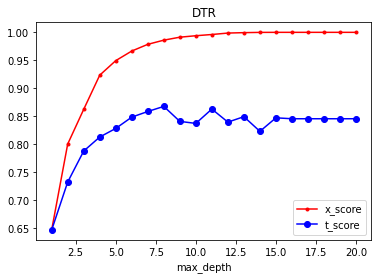

In [ ]:
# DecisionTreeRegressorで分類
max_score = 0
DTR_model = None
max_depth = 0
DTR_scores = []

num=20
for i in range(num):
  model = DecisionTreeRegressor(max_depth = i+1, random_state = 0)
  x_score, t_score = learn(x_train, y_train, model)
  DTR_scores.append( {'max_depth': i+1, 'x_score': x_score, 't_score': t_score} )
  if t_score > max_score:
    max_score = t_score
    DTR_model = model
    max_depth = i+1
  print(f"max_depth: {i+1:2} ... x_score: {x_score:.3f}, t_score: {t_score:.3f}")

print()
print(f"max_depth = {max_depth}で、正解率が{max_score:.3f}となる")

# 学習の度合いをグラフで表示
plot_progress(DTR_scores, title='DTR')


最後にテストデータを用いて検証を行う

In [ ]:
# 欠損値の確認
print(test.isnull().sum())

MPG             0
Cylinders       0
Displacement    0
Horsepower      1
Weight          0
Acceleration    0
Model Year      0
America         0
Europe          0
Japan           0
dtype: int64


In [ ]:
# 欠損値を含む行を抽出
condition = test['Horsepower'].isnull()
non_data = test.loc[condition]

non_data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
330,40.9,4,85.0,NaN,1835,17.3,80,0,1,0


In [ ]:
# 欠損値を除いたデータで値を予測
x = non_data.drop(['Horsepower'], axis=1)
pred = hp_regret_model.predict(x)

# 予測した値をセット
test2 = test.copy()
test2.loc[condition, 'Horsepower'] = pred

test2.loc[condition]

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
330,40.9,4,85.0,57.10319,1835,17.3,80,0,1,0


In [ ]:
# 正解データと特徴量とに分割
y_test = test2.loc[:, [t_col]]
y_test.head()


,MPG
65,14.0
132,25.0
74,13.0
78,21.0
37,18.0


In [ ]:
x_test = test2.loc[:, x_col]
x_test.head()

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,America,Europe,Japan
65,8,351.0,153.0,4129,13.0,72,1,0,0
132,4,140.0,75.0,2542,17.0,74,1,0,0
74,8,302.0,140.0,4294,16.0,72,1,0,0
78,4,120.0,87.0,2979,19.5,72,0,1,0
37,6,232.0,100.0,3288,15.5,71,1,0,0


In [ ]:
# 正解データを標準化
sc_y_test = sc_y.fit_transform(y_test)

In [ ]:
# 重回帰用の特徴量を抽出
x_test_LR = test2.loc[:, x_col_LR]
x_test_LR.head()

,Weight,Displacement,Horsepower,Cylinders
65,4129,351.0,153.0,8
132,2542,140.0,75.0,4
74,4294,302.0,140.0,8
78,2979,120.0,87.0,4
37,3288,232.0,100.0,6


In [ ]:
# 重回帰用に累乗列と交互作用特徴量を一括追加
pf_test_LR = PolynomialFeatures(degree=2, include_bias=False)
pf_x_test_LR = pf_test_LR.fit_transform(x_test_LR)
x_test_LR2 = pd.DataFrame(pf_x_test_LR)

# 列名の変更
x_test_LR2.columns = LR_columns

x_test_LR2.head()

,Weight,Displacement,Horsepower,Cylinders,Weight^2,Weight Displacement,Weight Horsepower,Weight Cylinders,Displacement^2,Displacement Horsepower,Displacement Cylinders,Horsepower^2,Horsepower Cylinders,Cylinders^2
0,4129.0,351.0,153.0,8.0,17048641.0,1449279.0,631737.0,33032.0,123201.0,53703.0,2808.0,23409.0,1224.0,64.0
1,2542.0,140.0,75.0,4.0,6461764.0,355880.0,190650.0,10168.0,19600.0,10500.0,560.0,5625.0,300.0,16.0
2,4294.0,302.0,140.0,8.0,18438436.0,1296788.0,601160.0,34352.0,91204.0,42280.0,2416.0,19600.0,1120.0,64.0
3,2979.0,120.0,87.0,4.0,8874441.0,357480.0,259173.0,11916.0,14400.0,10440.0,480.0,7569.0,348.0,16.0
4,3288.0,232.0,100.0,6.0,10810944.0,762816.0,328800.0,19728.0,53824.0,23200.0,1392.0,10000.0,600.0,36.0


In [ ]:
# 最終的な特徴量の抽出
x_test_LR = x_test_LR2.loc[:, LR_pattern]

x_test_LR.head()

,Horsepower,Cylinders,Weight Displacement,Weight Horsepower,Displacement^2,Displacement Horsepower,Displacement Cylinders,Horsepower^2,Cylinders^2
0,153.0,8.0,1449279.0,631737.0,123201.0,53703.0,2808.0,23409.0,64.0
1,75.0,4.0,355880.0,190650.0,19600.0,10500.0,560.0,5625.0,16.0
2,140.0,8.0,1296788.0,601160.0,91204.0,42280.0,2416.0,19600.0,64.0
3,87.0,4.0,357480.0,259173.0,14400.0,10440.0,480.0,7569.0,16.0
4,100.0,6.0,762816.0,328800.0,53824.0,23200.0,1392.0,10000.0,36.0


In [ ]:
# 重回帰用特徴量を標準化
sc_x_test_LR = sc_x_LR.fit_transform(x_test_LR)

In [ ]:
# リッジ回帰とラッソ回帰用に累乗列と交互作用特徴量を一括追加
pf = PolynomialFeatures(degree=2, include_bias=True)
x_test_pf = pf.fit_transform(x_test)

In [ ]:
# リッジ回帰とラッソ回帰用特徴量を標準化
sc_x_test = sc_x.fit_transform(x_test_pf)

In [ ]:
# LinearRegressionでテスト
print(f"重回帰  ... {LR_model.score(sc_x_test_LR, sc_y_test):.5f}")


# 特徴量選択無しのLinearRegressionでテスト
print(f"重回帰2 ... {model_LR_tmp.score(sc_x_test, sc_y_test):.5f}")


# Ridgeでテスト
print(f"リッジ  ... {R_model.score(sc_x_test, sc_y_test):.5f}")


# Lassoでテスト
print(f"ラッソ  ... {L_model.score(sc_x_test, sc_y_test):.5f}")


# DecisionTreeRegressorで分類
print(f"回帰木  ... {DTR_model.score(x_test, y_test):.5f}")

重回帰  ... 0.76654
重回帰2 ... 0.83247
リッジ  ... 0.85803
ラッソ  ... 0.87859
回帰木  ... 0.80678


以上により、もっとも精度の良い回帰は「ラッソ回帰」となった

In [ ]:
# モデルの保存

with open('auto_mpg_sc_y.pkl', 'wb') as f:
  pickle.dump(sc_y, f)
with open('auto_mpg_LR_sc.pkl', 'wb') as f:
  pickle.dump(sc_x_LR, f)
with open('auto_mpg_LR.pkl', 'wb') as f:
  pickle.dump(LR_model, f)
with open('auto_mpg_sc.pkl', 'wb') as f:
  pickle.dump(sc_x, f)
with open('auto_mpg_R.pkl', 'wb') as f:
  pickle.dump(R_model, f)
with open('auto_mpg_L.pkl', 'wb') as f:
  pickle.dump(L_model, f)
with open('auto_mpg_DTR.pkl', 'wb') as f:
  pickle.dump(DTR_model, f)